# Workspace \#8: Parameter Space

In [4]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md
import green as gr

In [6]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]
ga_cast = 6.e-11 # [GeV^-1]

In [7]:
help(gr.load_green_results)

Help on function load_green_results in module green:

load_green_results(name, r=None, tex=0.0, nuB=1.0)
    Function that loads the CCV numerical results for the SNRs from Green's Catalog.



### TODO: allow for ``r==None``, i.e., for SNRs with known age.

In [8]:
# SNR properties
r = 30.
tex = 0.
nuB = 8.

# axion parameters
ga_ref = 1.e-10
nu_pivot = 1.
ma_ref = pt.ma_from_nu(nu_pivot)

# reach:
sn_th = 2.
sigs_th = 2.
out_sigs = (gr.sigs_Gr > sigs_th)

min_ga = {}
min_ga_sigs = {}
pars_sigs = {}
for name, snr in tqdm(gr.snrs_cut.items()):
    
    sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(name, r=r, tex=tex, nuB=nuB)

    _, ga_Gr, _, _, no_Gr = gr.snr_reach(name,
                                         r=r,
                                         nuB=nuB,
                                         tex=tex,
                                         sn_ratio_threshold=sn_th,
                                         full_output=True)
    # minimum ga
    min_ga[name] = ga_Gr.min()
    
    # minimum ga within sigmas threshold
    ga_within = np.ma.masked_array(ga_Gr, mask=out_sigs)
    ga_lowest_idx = ga_within.argmin()
    ga_lowest = (ga_Gr.flatten())[ga_lowest_idx]
    
    min_ga_sigs[name] = ga_lowest
    pars_sigs[name] = {'tpk':(gr.pre_tpk_Gr.flatten())[ga_lowest_idx],
                       'Lpk':(gr.pre_Lpk_Gr.flatten())[ga_lowest_idx]}

100%|██████████| 61/61 [00:23<00:00,  2.61it/s]


In [10]:
min_key = min(min_ga, key=min_ga.__getitem__)
print("Absolute smallest ga in SNR: \n{}, ga = {}".format(min_key, min_ga[min_key]))

min_sigs_key = min(min_ga_sigs, key=min_ga_sigs.__getitem__)
print("\nSmallest ga within {}-sigmas in SNR:\n{}, ga = {}".format(int(sigs_th), min_sigs_key, min_ga_sigs[min_sigs_key]))
print("\tCorresponding parameters: {}".format(pars_sigs[min_sigs_key]))

Absolute smallest ga in SNR: 
G111.7-2.1, ga = 6.23870860303e-12

Smallest ga within 2-sigmas in SNR:
G4.5+6.8, ga = 1.77149109363e-10
	Corresponding parameters: {'Lpk': 1.1874815363065927e+28, 'tpk': 414.95404263436325}


In [19]:
# Exploring results:
name = min_sigs_key
snr = gr.snrs_cut[min_sigs_key]

print(name)

NL, Nt = 0., -3

Lpk = 10.**(ct._mu_log10_Lpk_ + NL*ct._sig_log10_Lpk_)
tpk = 10.**(ct._mu_log10_tpk_ + Nt*ct._sig_log10_tpk_)

L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha
new_Lpk = Lpk*from_Bieten_to_pivot

lightcurve_params = {'t_peak': tpk,
                     'L_peak': new_Lpk,
                     'L_today': L0}
t_trans = r*(lightcurve_params['t_peak']/365.)
lightcurve_params.update({'t_trans':t_trans})

t_age = ap.tage_compute(new_Lpk, tpk, t_trans, L0, gamma)

age_steps = abs(int(1000.*(log10(t_age) - log10(tpk/365.)) + 1))
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}

print("t_trans=%.1e, t_age=%.1e, tpk=%.1e" % (t_trans, t_age, tpk/365.))

md.snr_routine(ma_ref, ga_ref,
               snr,
               lightcurve_params=lightcurve_params,
               snu_echo_kwargs=snu_echo_kwargs,
               data=data,
               output_all=True,
               verbose=0)

G4.5+6.8
t_trans=8.2e-03, t_age=3.5e-02, tpk=2.7e-04


(5.089636049276657e-07,
 {'S/N': 5.089636049276657e-07,
  'echo_Snu': 9.64349071950905e-13,
  'ga': 1e-10,
  'ma': 8.27133561166016e-06,
  'noise_Omega_obs': 6.67162839535865e-07,
  'noise_Omega_res': array(7.20993788e-08),
  'noise_T408': array(53.29356384),
  'noise_Tnu': 31.14373926483961,
  'noise_delnu': 0.001,
  'noise_nu': 1.0,
  'noise_power': 4.489812394319843e-17,
  'signal_Omega': 6.67162839535865e-07,
  'signal_S_echo': 1.5426330585045127e-42,
  'signal_Snu': 9.64349071950905e-13,
  'signal_delnu': 0.001,
  'signal_nu': 1.0,
  'signal_power': 2.2851511016619417e-23})

In [20]:
# Selecting a SNR to explore:
name = min_sigs_key
snr = gr.snrs_cut[name]

sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(min_key, r=r, tex=tex, nuB=nuB)

_, ga_Gr, _, _, no_Gr = gr.snr_reach(min_key,
                                     r=r,
                                     nuB=nuB,
                                     tex=tex,
                                     sn_ratio_threshold=2.,
                                     full_output=True)

short_age = (time_Gr < r*(gr.pre_tpk_Gr/365.)).astype(int)

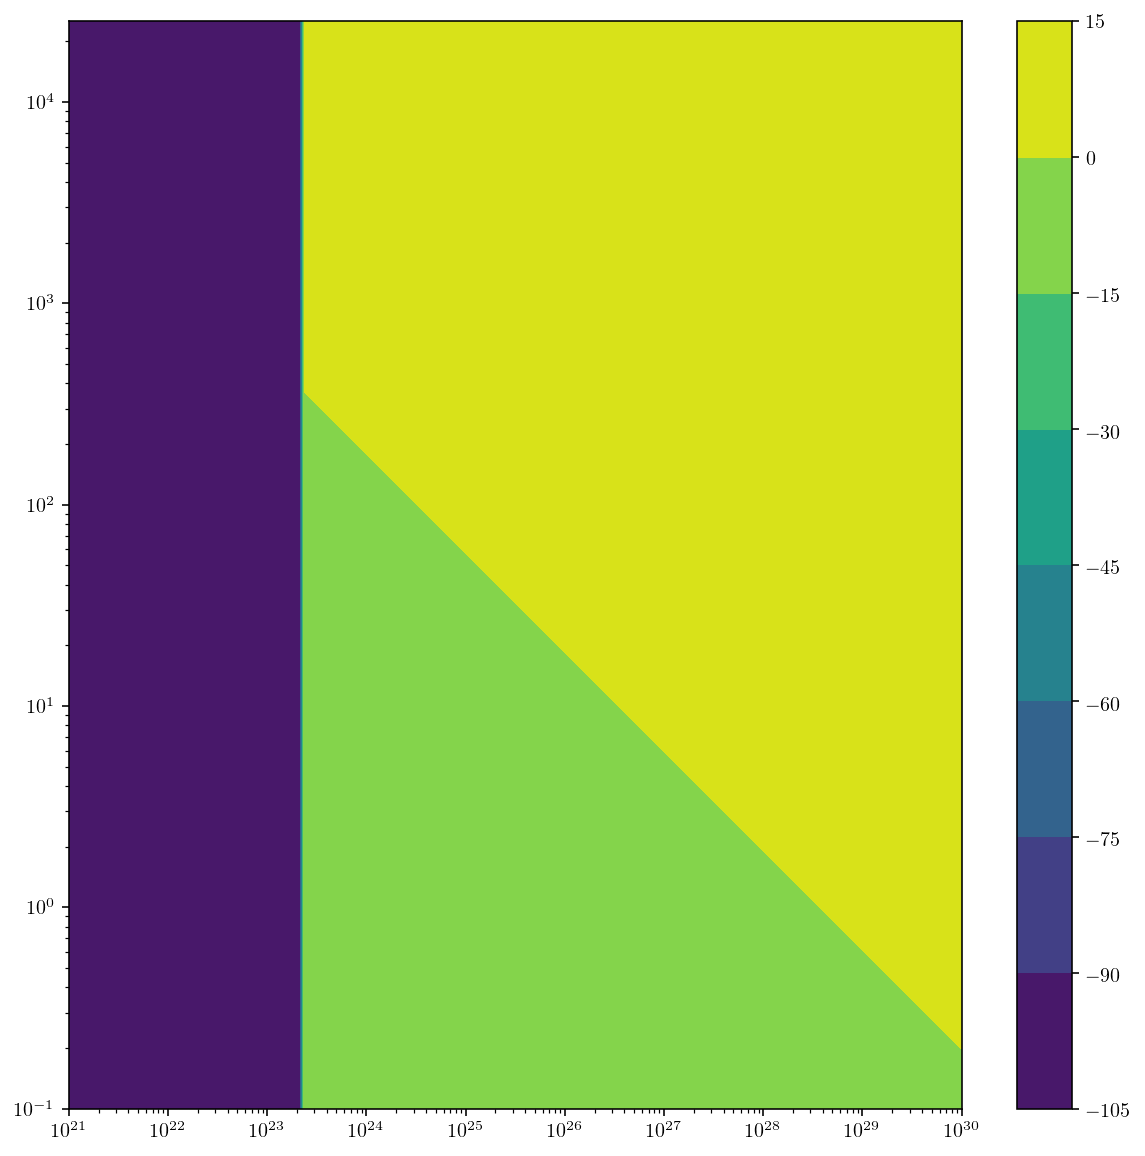

In [21]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

# contours for best possible ga
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(gr.pre_tpk_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(sn_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(echo_Gr))
cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(time_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, short_age)

fig.colorbar(cs)

plt.xscale("log"),plt.yscale("log");

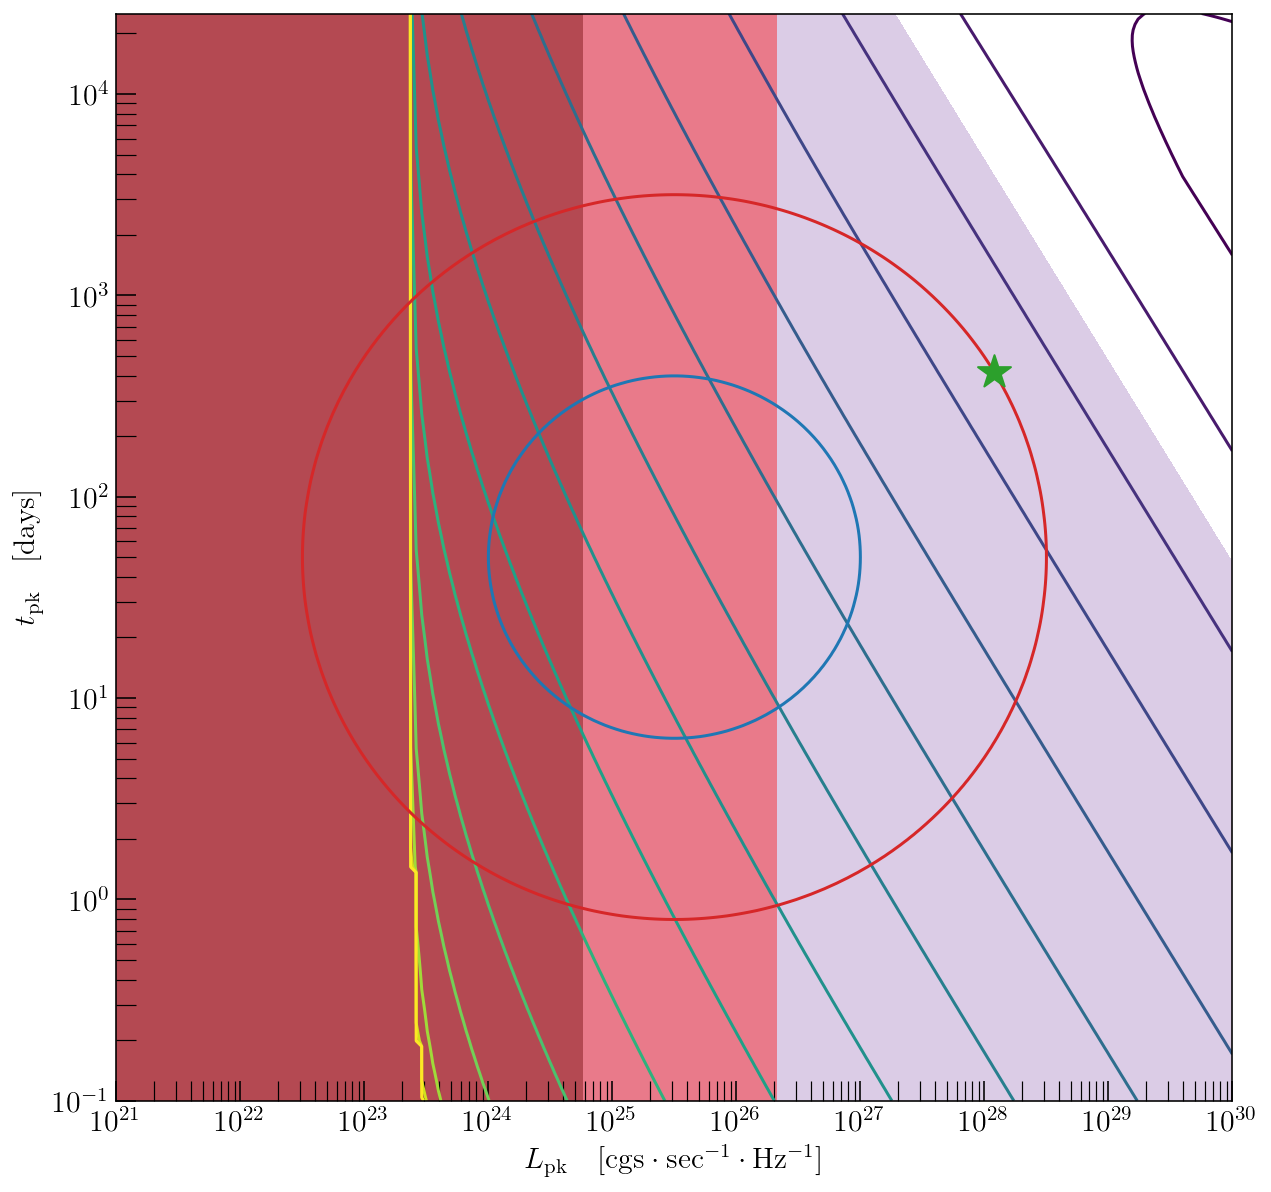

In [22]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

ga_lvls = np.arange(-14., -3.5, 0.5) # axion photon coupling levels
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha

# contours for best possible ga
ax.contour(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(ga_Gr), levels=ga_lvls)

ax.scatter(pars_sigs[name]['Lpk'], pars_sigs[name]['tpk'], s=300., zorder=10., marker='*', color="C2")

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['indigo'], alpha=0.2, zorder=-1)

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, no_Gr, levels=[0.999, 1.1], colors=['k'], alpha=0.4, zorder=-1)

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, short_age, levels=[0.999, 1.1], colors=['r'], alpha=0.4, zorder=-1)

ax.contour(gr.pre_Lpk_arr, gr.pre_tpk_arr, gr.sigs_Gr, levels=[1., 2.], colors=['C0', 'C3'], linestyles=['-', '-'])

plt.xscale("log"),plt.yscale("log");
ax.set_ylabel(r"$t_{\rm pk}\quad[\mathrm{days}]$", fontsize=label_sz);
ax.set_xlabel(r"$L_{\rm pk}\quad[\mathrm{cgs \cdot sec^{-1} \cdot Hz^{-1}}]$", fontsize=label_sz);
ax.set_xscale("log");ax.set_yscale("log");
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

In [27]:
# ma-ga
Lpk = pars_sigs[name]['Lpk']*from_Bieten_to_pivot
tpk = pars_sigs[name]['tpk']
L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)

light_curve_params = {'L_peak':Lpk,
                      't_peak':tpk,
                      'L_today':L0}

if r != None:
    t_trans = r*(tpk/365.)
    light_curve_params.update({'t_trans':t_trans})
    t_age = ap.tage_compute(Lpk, tpk, t_trans, L0, gamma)
else:
    t_age = snr.age
    light_curve_params.update({'t_age':t_age})


age_steps = int(1000.*(log10(t_age) - log10(tpk/365.)) + 1)
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}


nu_arr = np.concatenate((np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), 101), np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), 101)))
ma_arr = pt.ma_from_nu(nu_arr)

z, new_output = md.snr_routine(ma_arr, ga_ref,
                               snr,
                               gamma=gamma,
                               nu_pivot=nu_pivot,
                               lightcurve_params=light_curve_params,
                               snu_echo_kwargs=snu_echo_kwargs,
                               data=data,
                               output_all=True,
                               verbose=0)

ma_ga = ec.ma_ga_bound(2., ma_arr, z, ga_ref)

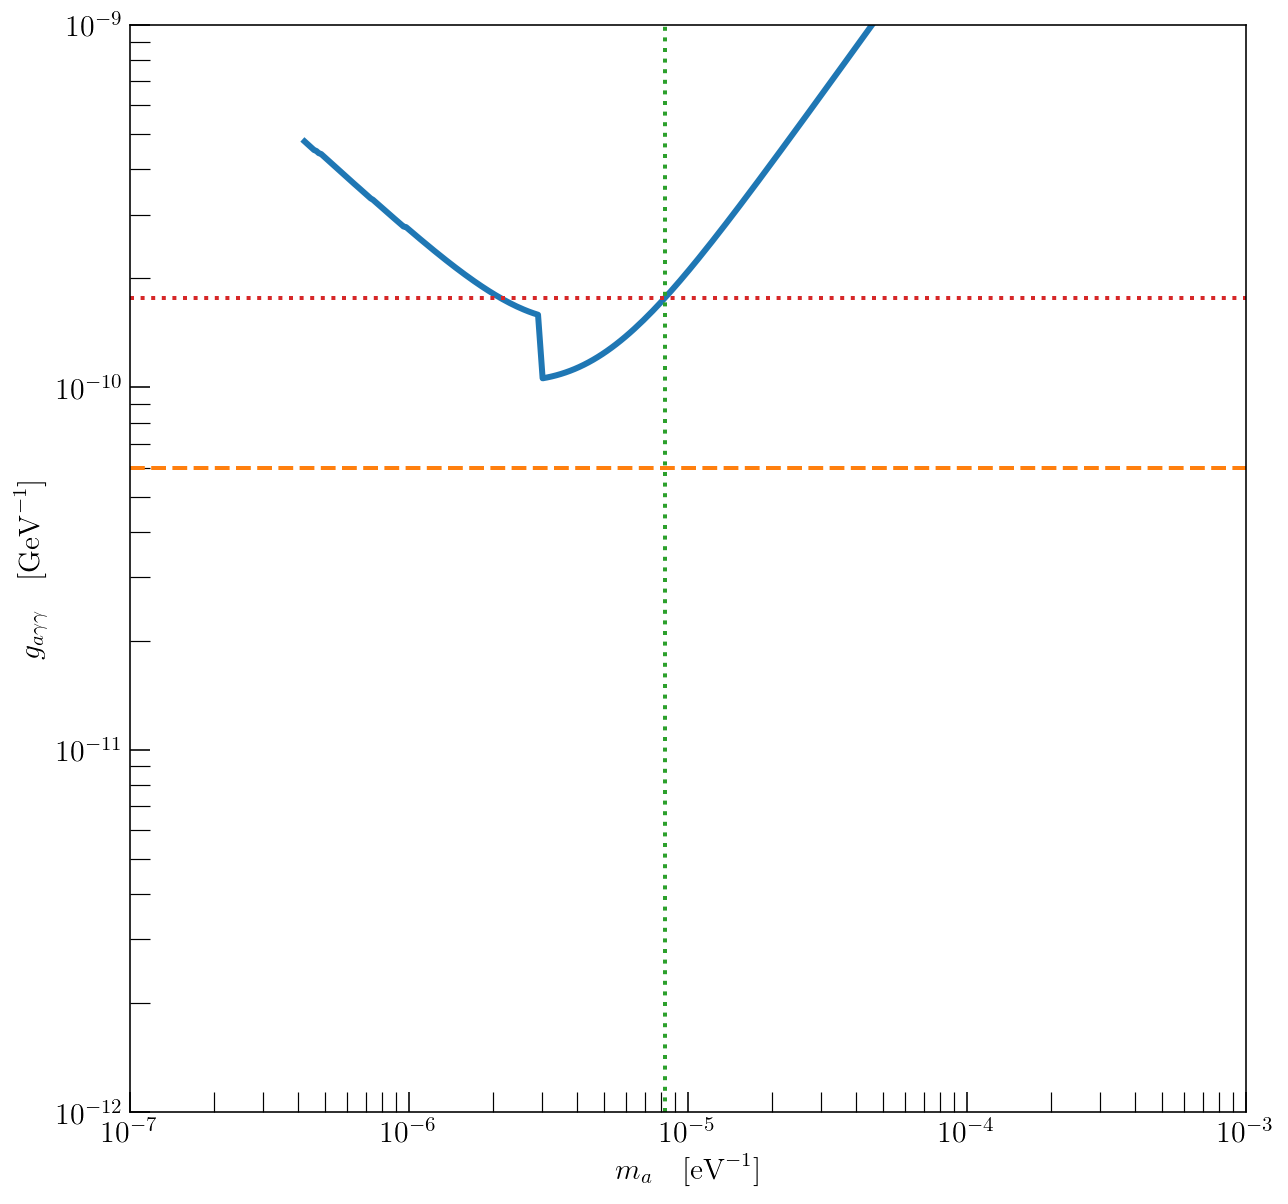

In [28]:
plt.loglog(ma_ga[:,0], ma_ga[:,1], lw=3., color='C0')
plt.axhline(ga_cast, lw=2., color='C1', ls="--")
plt.axvline(pt.ma_from_nu(1.), lw=2., color="C2", ls=":")
plt.axhline(min_ga_sigs[name], lw=2., color='C3', ls=":")

# plt.title(title, fontsize=title_sz);
plt.ylabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.xlabel(r"$m_a\quad[\mathrm{eV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);

plt.xlim(1.e-7, 1.e-3);plt.ylim(1.e-12, 1.e-9);
# plt.savefig(file_name, bbox_inches="tight")